In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

2025-04-11 20:58:08.755816: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 20:58:08.756789: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 20:58:08.759035: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 20:58:08.765508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744401488.778070  517905 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744401488.78

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
data = pd.read_csv('../data/energy_data_cleaned.csv')

In [4]:

X = data.drop(['target', 'timestamp'], axis=1)
y = data['target']


In [5]:
# split in train 60%, validation 20 and test 20 sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
# %% Scale target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


In [6]:
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())



In [7]:
def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', r2_metric, 'mse'])
    return model
input_dim = X_train_scaled.shape[1]
model = build_model(input_dim)
model.summary()

/home/cristiano/anaconda3/envs/env_ds/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-11 20:58:12.509306: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 384 (1.50 KB)

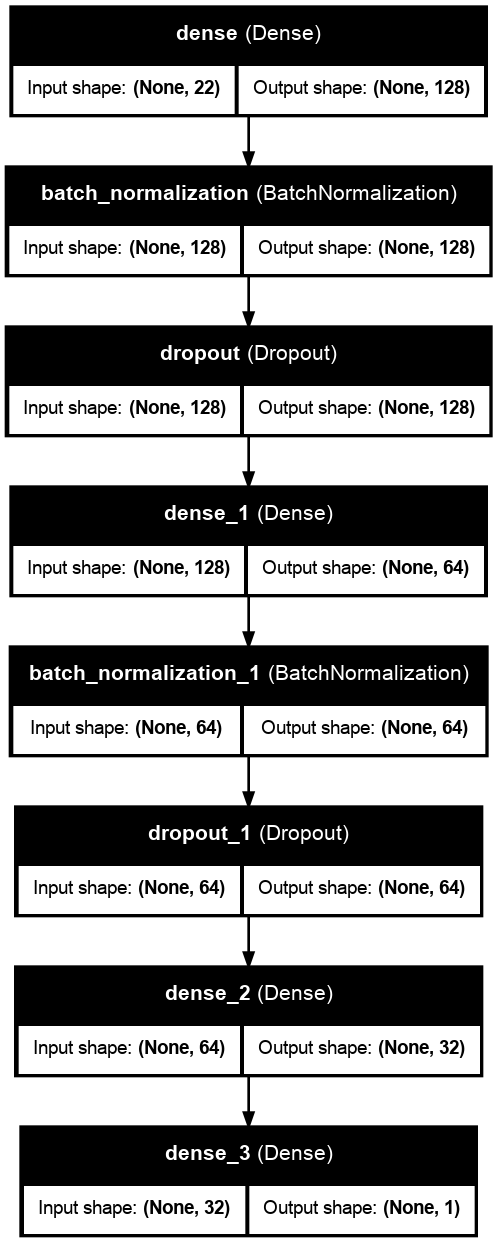

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file='model0_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)

In [8]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50, batch_size=64, verbose=1)


Epoch 1/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.1820 - mae: 0.2750 - mse: 0.1820 - r2_metric: 0.8112 - val_loss: 0.0267 - val_mae: 0.1116 - val_mse: 0.0267 - val_r2_metric: 0.9726
Epoch 2/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0325 - mae: 0.1256 - mse: 0.0325 - r2_metric: 0.9665 - val_loss: 0.0218 - val_mae: 0.0970 - val_mse: 0.0218 - val_r2_metric: 0.9776
Epoch 3/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0270 - mae: 0.1110 - mse: 0.0270 - r2_metric: 0.9721 - val_loss: 0.0256 - val_mae: 0.1114 - val_mse: 0.0256 - val_r2_metric: 0.9738
Epoch 4/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.0249 - mae: 0.1049 - mse: 0.0249 - r2_metric: 0.9743 - val_loss: 0.0227 - val_mae: 0.1013 - val_mse: 0.0227 - val_r2_metric: 0.9768
Epoch 5/50
9829/9829 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0236 - mae: 0.1013 - mse: 0.0236 - r2_metric: 0.9756 - val_loss: 0.0242 - val_mae: 0.1075 - val_mse: 0.0242 - val_r2_metric: 0.9752
Epoch 6/50
9829

In [9]:
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_orig = scaler_y.inverse_transform(y_test_scaled)

# Métricas de desempenho
mae = mean_absolute_error(y_test_orig, predictions)
mse = mean_squared_error(y_test_orig, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, predictions)

print(f"Test- MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")


6553/6553 ━━━━━━━━━━━━━━━━━━━━ 4s 560us/step
Test- MAE: 0.1445, MSE: 0.0467, RMSE: 0.2161, R2: 0.9823


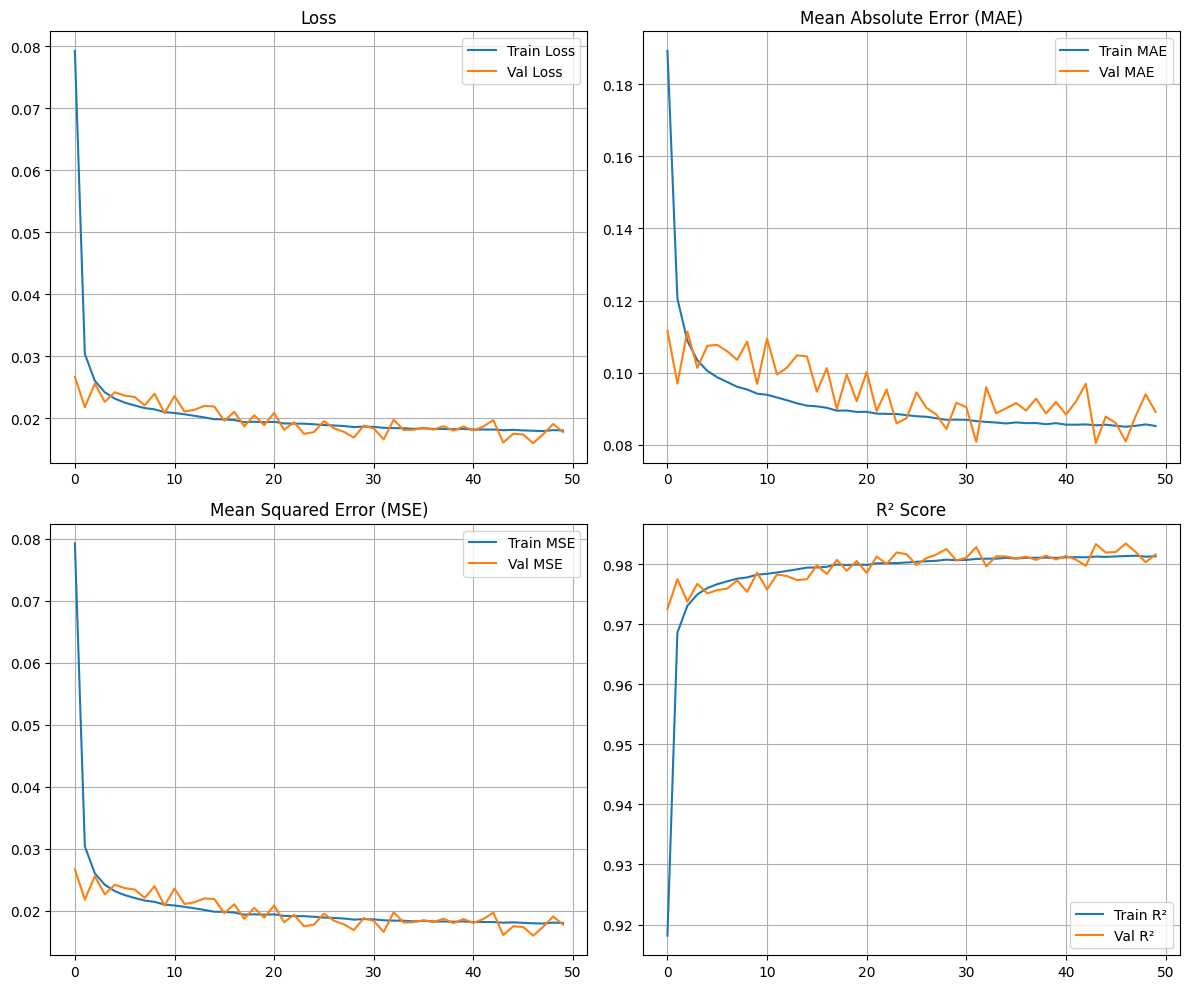

In [10]:
# Visualização do desempenho durante o treinamento
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.grid(True)

# Plot MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.grid(True)

# Plot MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.title('Mean Squared Error (MSE)')
plt.grid(True)

# Plot R²
plt.subplot(2, 2, 4)
plt.plot(history.history['r2_metric'], label='Train R²')
plt.plot(history.history['val_r2_metric'], label='Val R²')
plt.legend()
plt.title('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

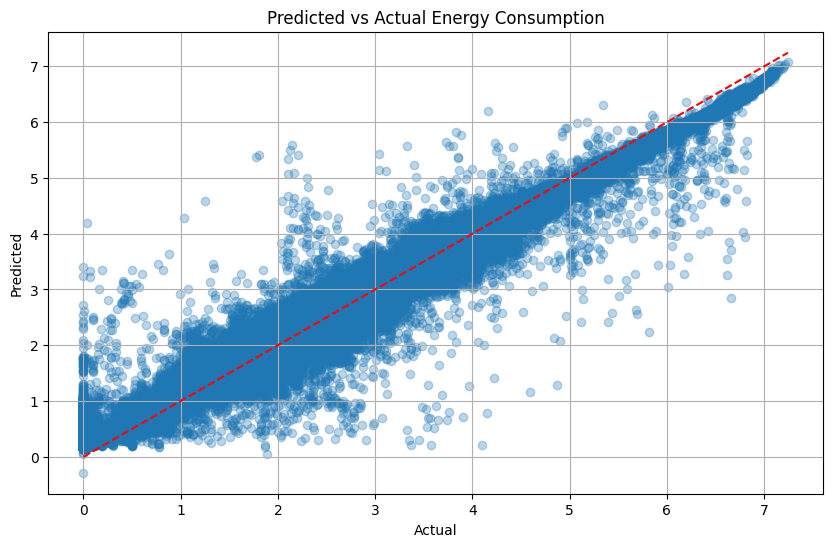

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, predictions, alpha=0.3)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Energy Consumption')
plt.grid(True)
plt.show()


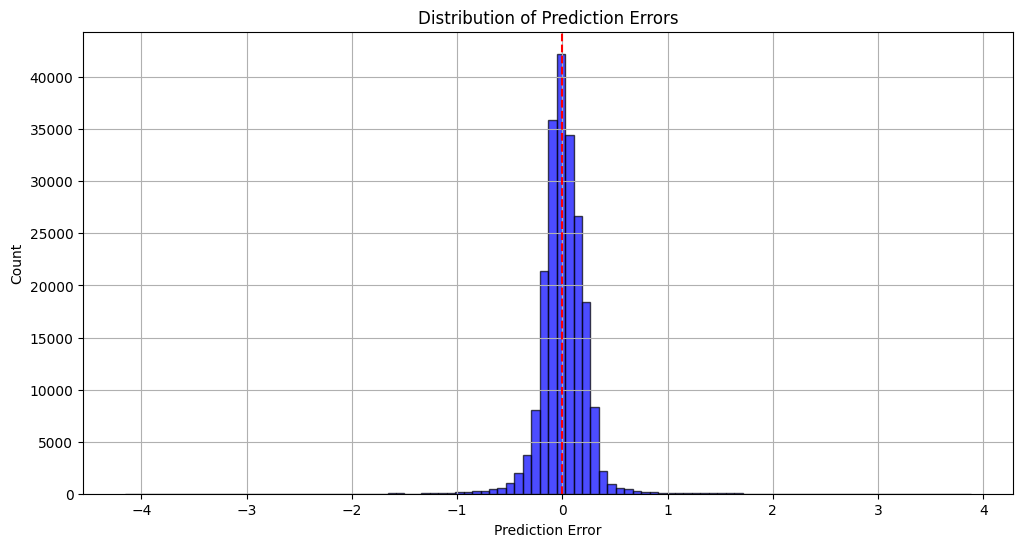

Error Analysis:
Mean Error: 0.0090
Standard Deviation of Error: 0.2160


In [13]:
error = y_test_orig - predictions
plt.figure(figsize=(12, 6))
plt.hist(error, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()

print("Error Analysis:")
print(f"Mean Error: {np.mean(error):.4f}")
print(f"Standard Deviation of Error: {np.std(error):.4f}")


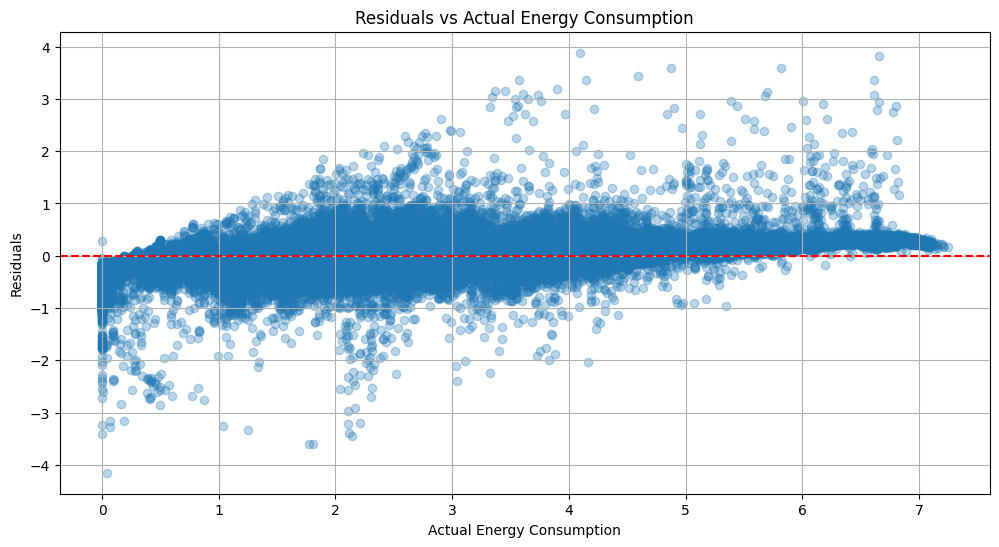

In [15]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test_orig, error, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Energy Consumption')
plt.grid(True)
plt.show()